<a href="https://colab.research.google.com/github/shavindukesara/Telco-Churn-Predictor/blob/main/models/neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Missing TotalCharges: 11
Features shape: (7043, 30)
Target distribution:
Churn
0    5174
1    1869
Name: count, dtype: int64
Training set: (5634, 30)
Test set: (1409, 30)
Preprocessing complete
Class Weights: {0: np.float64(0.6805991785455424), 1: np.float64(1.8842809364548494)}

Hyperparameter Tuning...
Testing LR=0.001, Batch=32


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  Validation AUC: 0.8389
Testing LR=0.0005, Batch=64
  Validation AUC: 0.8380

Best Config: LR=0.001, Batch=32

Training final model...
Epoch 1/80
141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.5265 - auc: 0.5598 - loss: 0.8302 - val_accuracy: 0.6415 - val_auc: 0.7707 - val_loss: 0.6060 - learning_rate: 0.0010
Epoch 2/80
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6138 - auc: 0.6807 - loss: 0.6642 - val_accuracy: 0.6486 - val_auc: 0.7997 - val_loss: 0.5937 - learning_rate: 0.0010
Epoch 3/80
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6248 - auc: 0.7227 - loss: 0.6309 - val_accuracy: 0.6646 - val_auc: 0.8096 - val_loss: 0.5731 - learning_rate: 0.0010
Epoch 4/80
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6571 - auc: 0.7507 - loss: 0.5970 - val_accuracy: 0.6859 - val_auc: 0.8160 - val_loss: 0.5671 - learning_rate: 0.0010
Epoch 5/80
141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6871 - auc: 0.7820 - loss: 0.5731 - val_accuracy: 0.6992 - val

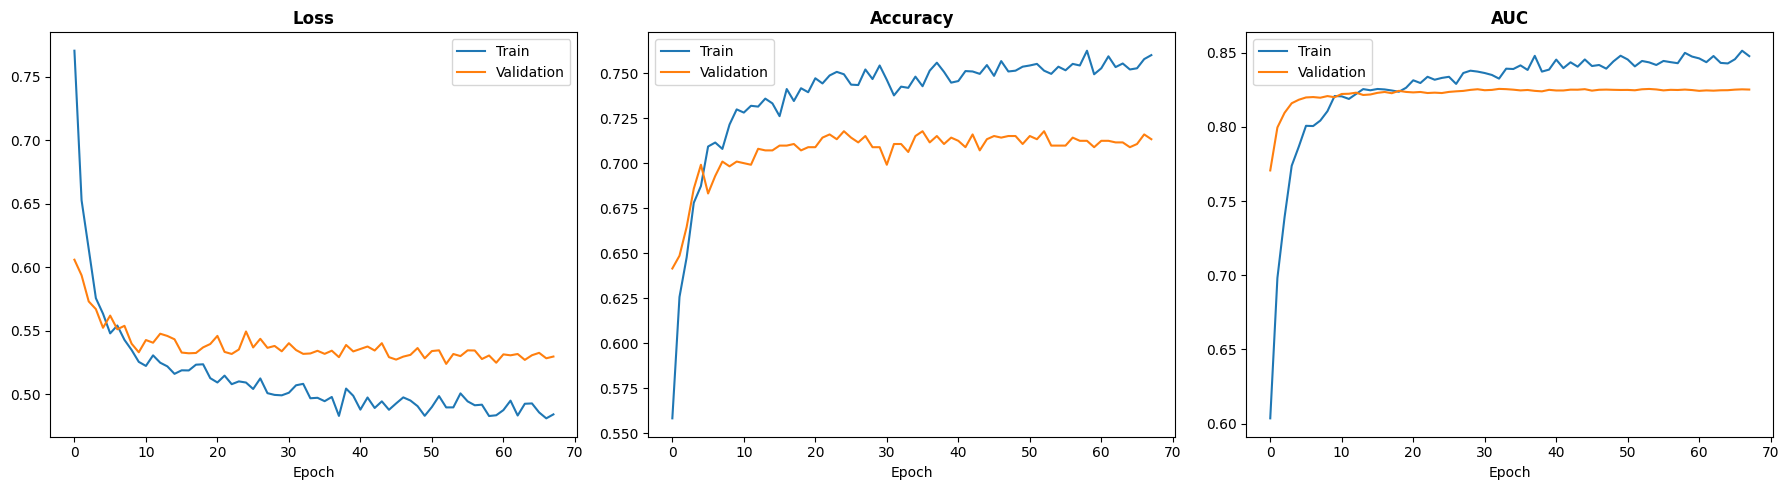

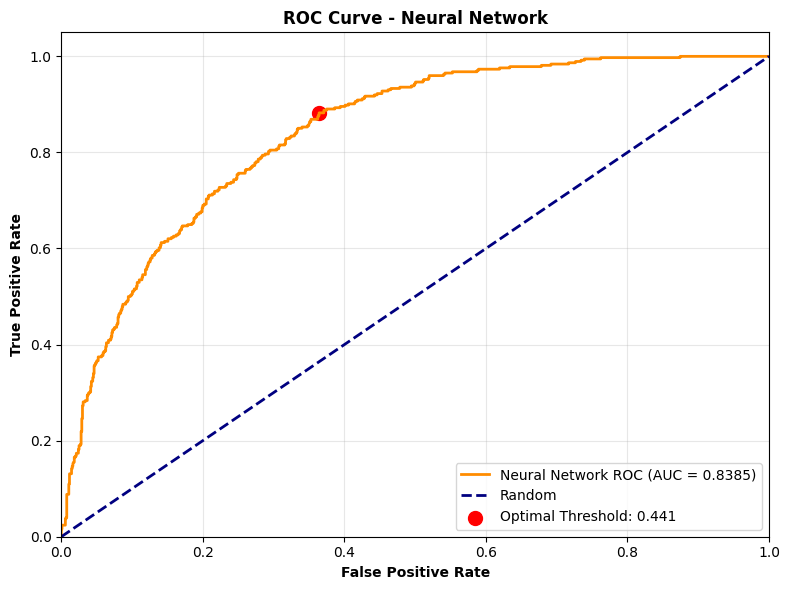

In [1]:
!pip install -q scikit-learn tensorflow pandas numpy matplotlib seaborn
!pip install scikeras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (classification_report, confusion_matrix,
                            accuracy_score, precision_score, recall_score,
                            f1_score, roc_auc_score, roc_curve, auc)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'
df = pd.read_csv(url)

df_processed = df.copy()

# Handle missing values
df_processed['TotalCharges'] = pd.to_numeric(df_processed['TotalCharges'], errors='coerce')
print(f"Missing TotalCharges: {df_processed['TotalCharges'].isnull().sum()}")

#used direct assignment instead of inplace=True
df_processed['TotalCharges'] = df_processed['TotalCharges'].fillna(df_processed['TotalCharges'].median())

# Drop non-predictive columns
df_processed = df_processed.drop(['customerID', 'TenureGroup'], axis=1, errors='ignore')

# Encode binary variables
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
for col in binary_cols:
    df_processed[col] = df_processed[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})


multi_class_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity',
                    'OnlineBackup', 'DeviceProtection', 'TechSupport',
                    'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']
df_processed = pd.get_dummies(df_processed, columns=multi_class_cols, drop_first=True, dtype=int)

# Encode target
df_processed['Churn'] = df_processed['Churn'].map({'Yes': 1, 'No': 0})

# Separate features and target
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

print(f"Features shape: {X.shape}")
print(f"Target distribution:\n{y.value_counts()}")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print("Preprocessing complete")


# Calculating class weights
class_weights_array = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights_array[i] for i in range(len(class_weights_array))}
print(f"Class Weights: {class_weights}")

# Build model
def create_nn_model(input_dim, learning_rate=0.001):
    model = Sequential([
        Dense(64, activation='relu', input_dim=input_dim),
        BatchNormalization(),
        Dropout(0.5),

        Dense(32, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),

        Dense(16, activation='relu'),
        Dropout(0.3),

        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    return model

# Hyperparameter tuning
print("\nHyperparameter Tuning...")
configs = [
    {'learning_rate': 0.001, 'batch_size': 32},
    {'learning_rate': 0.0005, 'batch_size': 64},
]

best_score = 0
best_config = None

for config in configs:
    print(f"Testing LR={config['learning_rate']}, Batch={config['batch_size']}")

    model = create_nn_model(X_train_scaled.shape[1], config['learning_rate'])

    history = model.fit(
        X_train_scaled, y_train,
        epochs=30,
        batch_size=config['batch_size'],
        validation_split=0.2,
        class_weight=class_weights,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=0)
        ],
        verbose=0
    )

    _, _, val_auc = model.evaluate(X_test_scaled, y_test, verbose=0)
    print(f"  Validation AUC: {val_auc:.4f}")

    if val_auc > best_score:
        best_score = val_auc
        best_config = config
        best_model = model

print(f"\nBest Config: LR={best_config['learning_rate']}, Batch={best_config['batch_size']}")

# Train final model
print("\nTraining final model...")
nn_final = create_nn_model(X_train_scaled.shape[1], best_config['learning_rate'])

history = nn_final.fit(
    X_train_scaled, y_train,
    epochs=80,
    batch_size=best_config['batch_size'],
    validation_split=0.2,
    class_weight=class_weights,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=15, min_delta=0.001, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=8, verbose=1)
    ],
    verbose=1
)

# Evaluate
y_pred_proba_nn = nn_final.predict(X_test_scaled).flatten()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_nn)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"\nOptimal threshold: {optimal_threshold:.3f}")

y_pred_nn = (y_pred_proba_nn > optimal_threshold).astype(int)

print("\n--- NEURAL NETWORK RESULTS ---")
print(classification_report(y_test, y_pred_nn, target_names=['No Churn', 'Churn']))

cm_nn = confusion_matrix(y_test, y_pred_nn)
print(f"Confusion Matrix:\n{cm_nn}")

nn_metrics = {
    'Accuracy': accuracy_score(y_test, y_pred_nn),
    'Precision': precision_score(y_test, y_pred_nn),
    'Recall': recall_score(y_test, y_pred_nn),
    'F1-Score': f1_score(y_test, y_pred_nn),
    'ROC-AUC': roc_auc_score(y_test, y_pred_proba_nn)
}

print("\nMetrics:")
for metric, value in nn_metrics.items():
    print(f"  {metric}: {value:.4f}")

# Training History
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].plot(history.history['loss'], label='Train')
axes[0].plot(history.history['val_loss'], label='Validation')
axes[0].set_title('Loss', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].legend()

axes[1].plot(history.history['accuracy'], label='Train')
axes[1].plot(history.history['val_accuracy'], label='Validation')
axes[1].set_title('Accuracy', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].legend()

axes[2].plot(history.history['auc'], label='Train')
axes[2].plot(history.history['val_auc'], label='Validation')
axes[2].set_title('AUC', fontweight='bold')
axes[2].set_xlabel('Epoch')
axes[2].legend()

plt.tight_layout()
plt.show()

# ROC Curve for Neural Network
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'Neural Network ROC (AUC = {nn_metrics["ROC-AUC"]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', s=100,
            label=f'Optimal Threshold: {optimal_threshold:.3f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontweight='bold')
plt.ylabel('True Positive Rate', fontweight='bold')
plt.title('ROC Curve - Neural Network', fontweight='bold')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()